<a href="https://colab.research.google.com/github/mohithxoxo/Project/blob/master/METROPOLIS_HASTINGS_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)
import pandas_datareader.data as web
import datetime
!pip install pymc3==3.8
import pymc3
!pip install arviz
import arviz

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
start = datetime.datetime(2010, 5, 1)
SP500 = web.DataReader(['sp500'], 'fred',start)
df = SP500

In [0]:
df = df.dropna()

In [0]:
df = df['sp500'].rename('Close')
df = pd.DataFrame(df)

In [8]:
df

,Close
DATE,
2010-05-07,1110.88
2010-05-10,1159.73
2010-05-11,1155.79
2010-05-12,1171.67
2010-05-13,1157.44
...,...
2020-04-30,2912.43
2020-05-01,2830.71
2020-05-04,2842.74


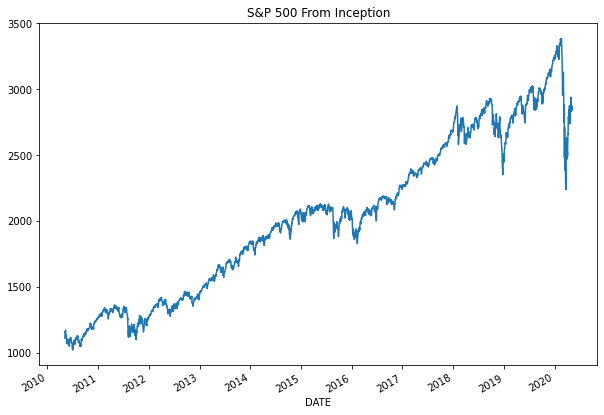

In [9]:
close = pd.Series(df.Close.values,index=pd.DatetimeIndex(df.index))
close = close[::-1]
close.plot(title='S&P 500 From Inception');

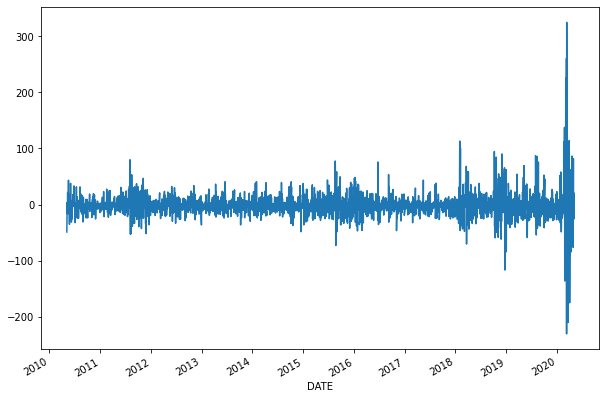

In [10]:
returns = pd.Series(np.diff(close.values),index=close.index[1:])
returns.plot()


In [0]:
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
with pm.Model() as model:
    step_size = pm.Exponential('sigma', 50.) #1
    s = GaussianRandomWalk('s', sd=step_size, #2
                           shape=len(returns))
    nu = pm.Exponential('nu', .1) #3
    r = pm.StudentT('r', nu=nu, #4
                    lam=pm.math.exp(-2*s),
                    observed=returns.values)

In [12]:
with model:
    trace = pm.sample(tune=2000, nuts_kwargs=dict(target_accept=.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, s, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 2500/2500 [06:19<00:00,  6.58it/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.6/dist-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4379ba0208>,
      dtype=object)

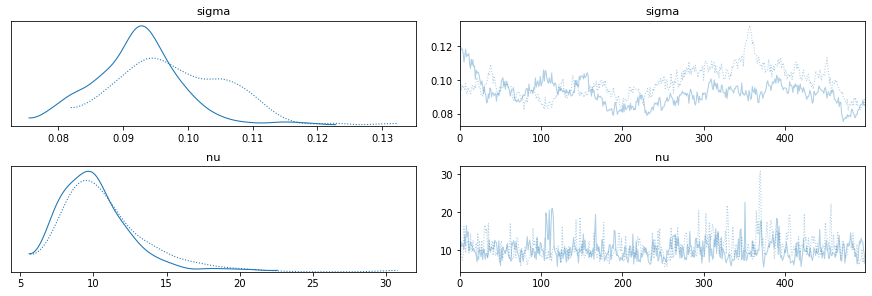

In [13]:
pymc3.traceplot(trace,varnames=['sigma', 'nu'])

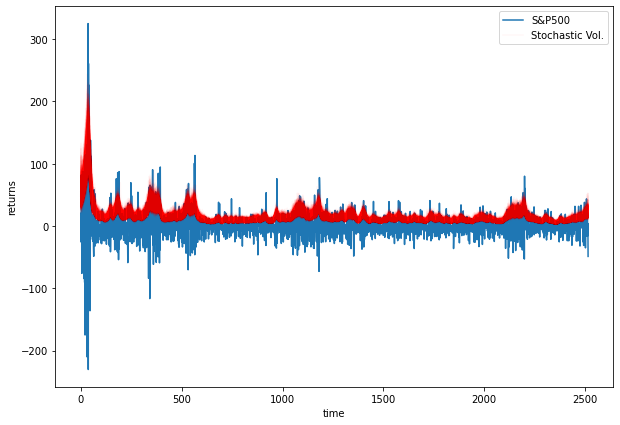

In [14]:
plt.plot(returns.values)
plt.plot(np.exp(trace[s].T), 'r', alpha=.03);
plt.xlabel('time') 
plt.ylabel('returns')
plt.legend(['S&P500', 'Stochastic Vol.']);